In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("final_merged_5.csv", index_col=0)
data = data.drop(columns=["MP_diff(y)"])
data = data.dropna(axis = 0)
len(data)

21957

Number of Features 56


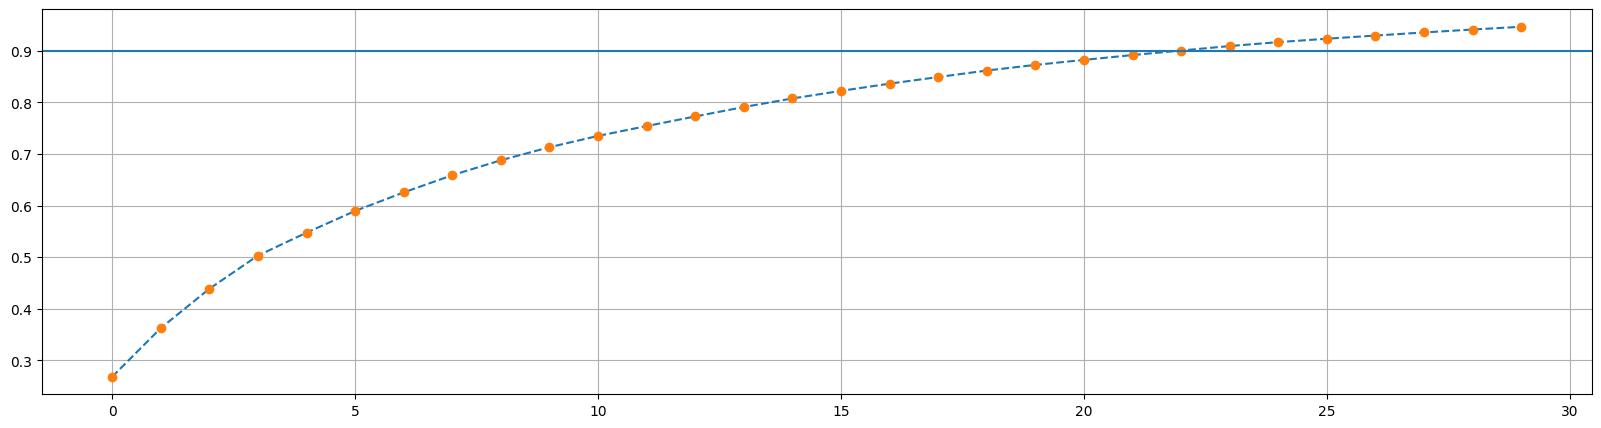

In [242]:
# scale features

x_features = list(data)
x_features.remove("MP_perc(y)")
x_features.remove("DAY")
print("Number of Features", len(x_features))

# scale data between 0 and 1
for col in x_features:
    #data[col] = np.log(data[col] + data[col].min())
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# apply pca
from sklearn.decomposition import PCA
import numpy as np

pca_features = x_features[:]
pca_features.remove("ENDT")
pca = PCA(n_components=30)
pca_vectors = pca.fit_transform(data[pca_features])

plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linestyle = "--")
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(0.9)
plt.grid()

In [243]:
X_pca = pca_vectors[:,:13]

In [244]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data[x_features].to_numpy() # pd dataframe of x features
y = data["MP_perc(y)"].to_numpy()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
test_loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7981 - val_loss: 0.1829
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 - val_loss: 0.0601
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0507 - val_loss: 0.0265
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0242 - val_loss: 0.0151
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0144 - val_loss: 0.0103
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 12/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

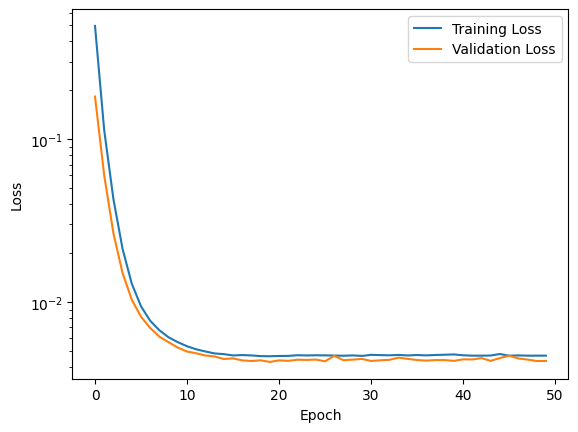

In [246]:
# Optionally, you can plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale("log")
plt.show()

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


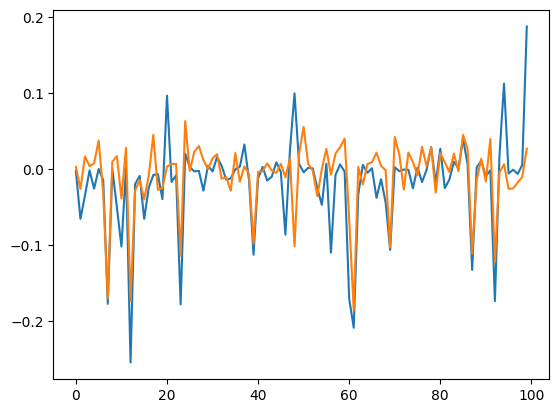

In [247]:
y_pred = model.predict(X_test_scaled).flatten()
plt.plot(y_test[:100])
plt.plot(y_pred[:100])

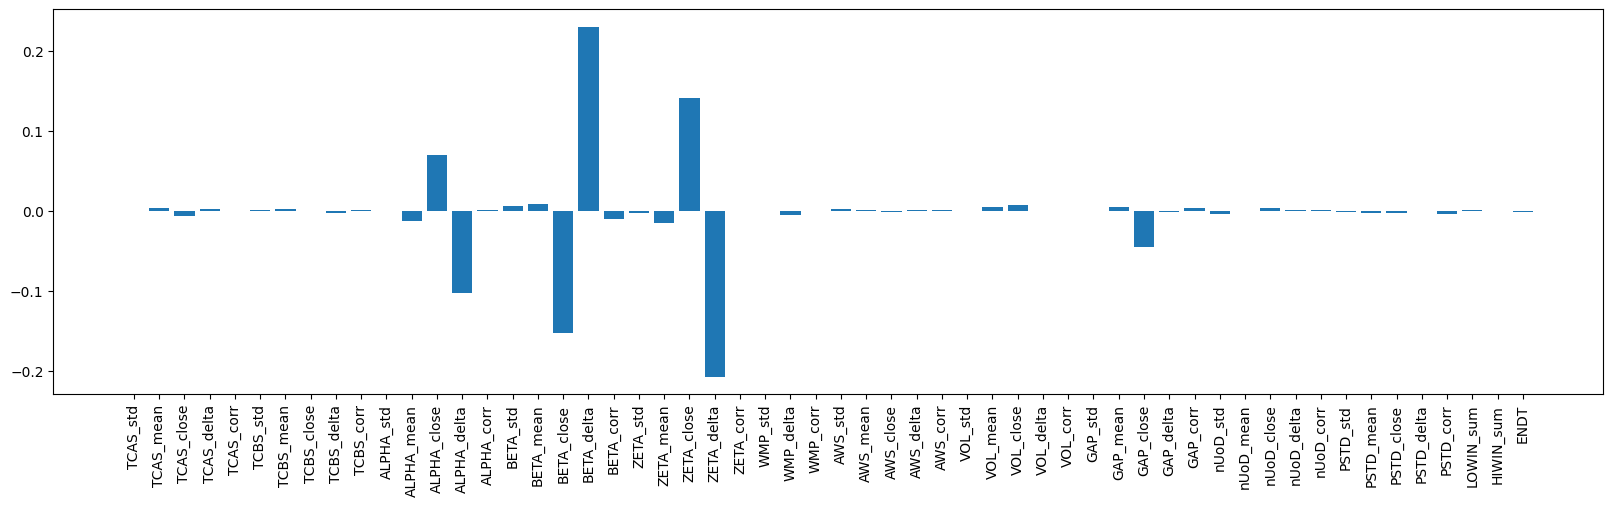

In [248]:
plt.figure(figsize=(20,5))
plt.bar(x_features,np.array(model.weights[0]).flatten()[:56])
plt.xticks(rotation = 90)
plt.show()

In [249]:
# For greater than 0
true_positives = np.sum((y_pred[y_test > 0] > 0))
false_negatives = np.sum((y_pred[y_test > 0] <= 0))
false_positives = np.sum((y_pred[y_test <= 0] > 0))

recall_positive = true_positives / (true_positives + false_negatives)
precision_positive = true_positives / (true_positives + false_positives)
f1_score_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)

# For less than 0
true_negatives = np.sum((y_pred[y_test < 0] <= 0))
false_positives = np.sum((y_pred[y_test < 0] > 0))
false_negatives = np.sum((y_pred[y_test >= 0] < 0))

recall_negative = true_negatives / (true_negatives + false_positives)
precision_negative = true_negatives / (true_negatives + false_negatives)
f1_score_negative = 2 * (precision_negative * recall_negative) / (precision_negative + recall_negative)


# Print out the results
print("Metrics for class > 0:")
print(f"Recall: {recall_positive:.2f}")
print(f"Precision: {precision_positive:.2f}")
print(f"F1-score: {f1_score_positive:.2f}")
print()
print("Metrics for class < 0:")
print(f"Recall: {recall_negative:.2f}")
print(f"Precision: {precision_negative:.2f}")
print(f"F1-score: {f1_score_negative:.2f}")


Metrics for class > 0:
Recall: 0.67
Precision: 0.58
F1-score: 0.62

Metrics for class < 0:
Recall: 0.55
Precision: 0.65
F1-score: 0.60


(array([   7.,   16.,   80.,  200., 1618., 2266.,  155.,   41.,    6.,
           3.]),
 array([-4.34667522e-01, -3.47773836e-01, -2.60880150e-01, -1.73986464e-01,
        -8.70927781e-02, -1.99092238e-04,  8.66945936e-02,  1.73588280e-01,
         2.60481965e-01,  3.47375651e-01,  4.34269337e-01]),
 <BarContainer object of 10 artists>)

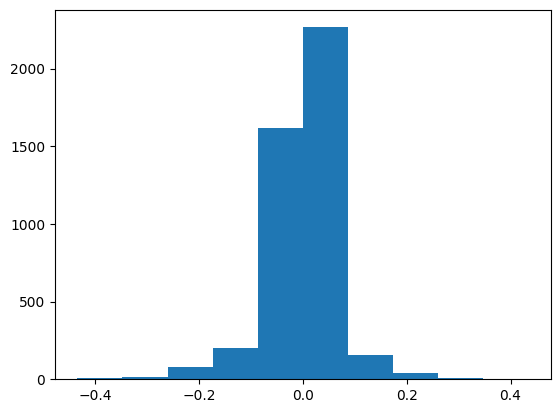

In [250]:
plt.hist(y_pred - y_test)

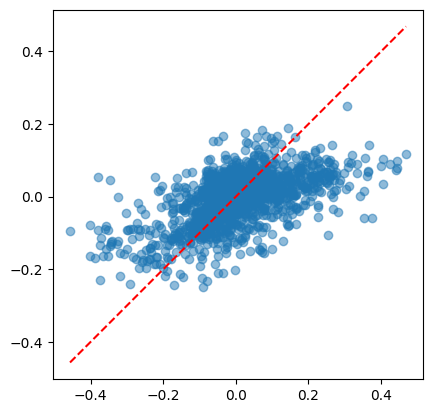

In [251]:
import matplotlib.pyplot as plt

# Determine the limits for the x and y axes
xmin = min(y_test.min(), y_pred.min())
xmax = max(y_test.max(), y_pred.max())

# Plot the points
plt.plot(y_test, y_pred, 'o', alpha = 0.5)

# Plot the line y = x
plt.plot([xmin, xmax], [xmin, xmax], color='red', linestyle='--')

# Set the aspect ratio of the plot to 'equal'
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


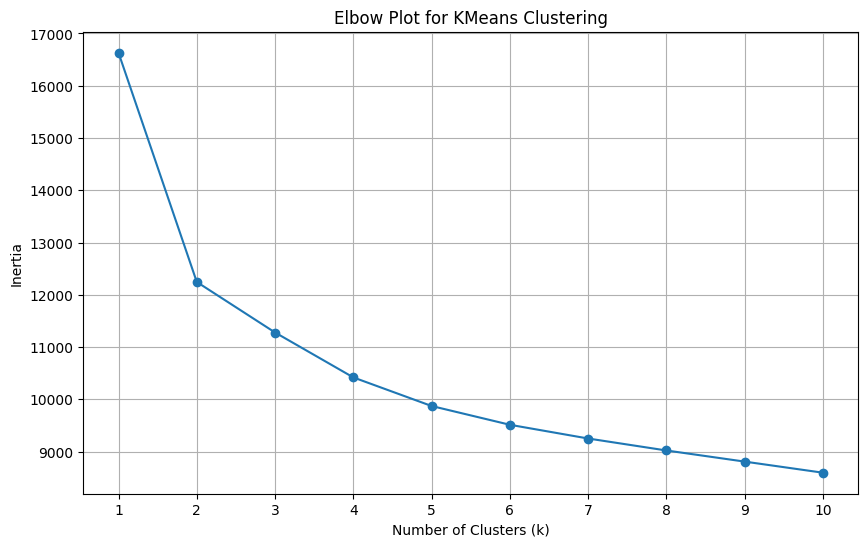

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create an array to store the inertia values
inertia = []

# Define the range of clusters to try
k_range = range(1, 11)  # Adjust the upper limit of the range as needed

# Calculate inertia for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Plot for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()


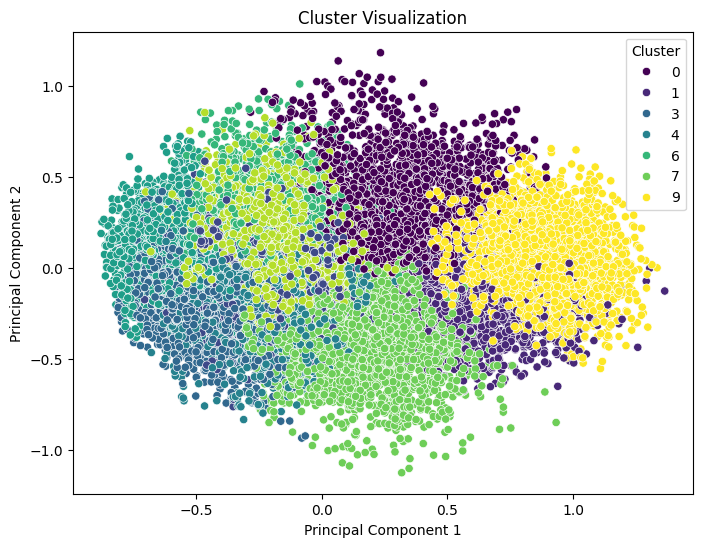

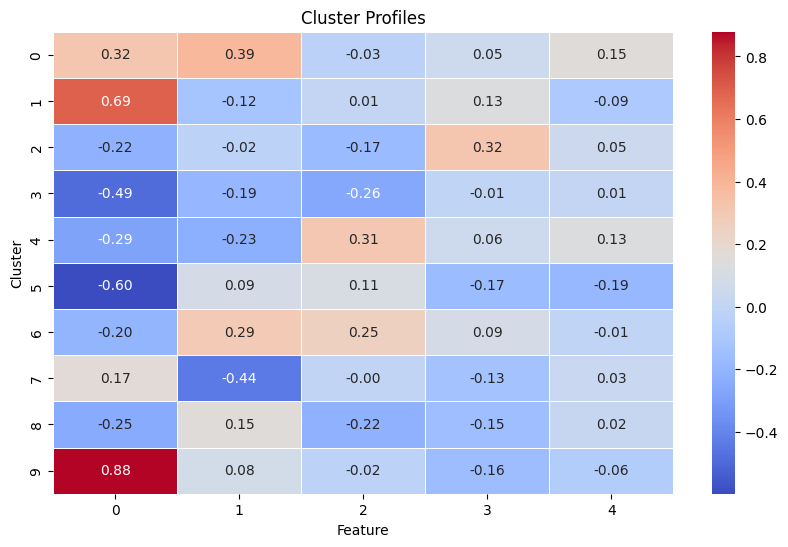

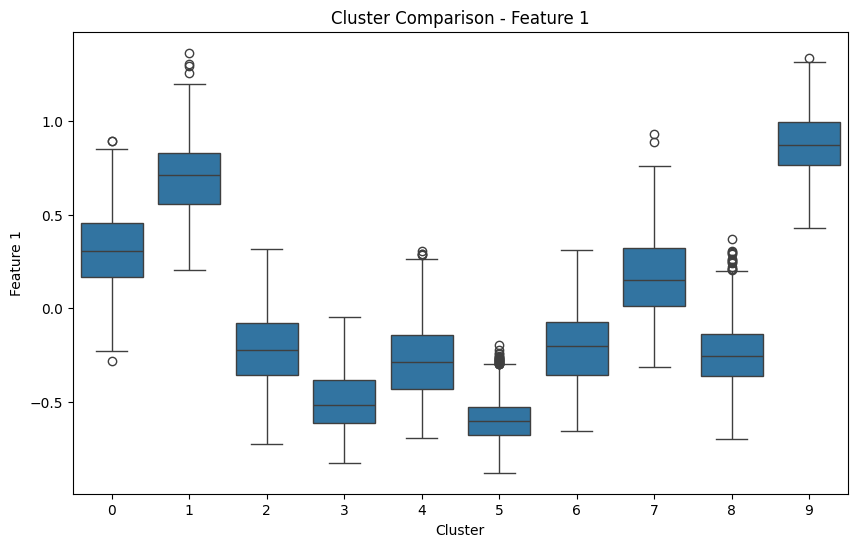

In [254]:
import seaborn as sns

x_pca = X_pca

# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_pca)

# Assign cluster labels to the data
cluster_labels = kmeans.labels_

# Add cluster labels to the original data (if needed)
data_with_clusters = pd.concat([pd.DataFrame(x_pca), pd.DataFrame({'Cluster': cluster_labels})], axis=1)

# Visualize cluster distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=cluster_labels, palette='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Calculate cluster profiles
cluster_means = data_with_clusters.groupby('Cluster').mean()

# Visualize cluster profiles (example for the first few features)
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.iloc[:, :5], cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.title('Cluster Profiles')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.show()

# Cluster comparison (example for the first feature)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=data_with_clusters.columns[0], data=data_with_clusters)
plt.title('Cluster Comparison - Feature 1')
plt.xlabel('Cluster')
plt.ylabel('Feature 1')
plt.show()
